In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 10)

data = pd.read_csv('Default_Data.csv', low_memory=False)
print(f"Ham Veri Seti Boyutu: {data.shape}")

data['CRASH DATE'] = pd.to_datetime(data['CRASH DATE'], errors='coerce')
data['CRASH TIME'] = pd.to_datetime(data['CRASH TIME'], format='%H:%M', errors='coerce')

data['YEAR'] = data['CRASH DATE'].dt.year
data['MONTH'] = data['CRASH DATE'].dt.month
data['DAY_OF_WEEK'] = data['CRASH DATE'].dt.day_name()
data['HOUR'] = data['CRASH TIME'].dt.hour

columns_to_drop = [
    'VEHICLE TYPE CODE 3', 'CONTRIBUTING FACTOR VEHICLE 3',
    'VEHICLE TYPE CODE 4', 'CONTRIBUTING FACTOR VEHICLE 4',
    'VEHICLE TYPE CODE 5', 'CONTRIBUTING FACTOR VEHICLE 5',
    'COLLISION_ID', 'LOCATION'
]
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

data.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
data = data[(data['LATITUDE'] != 0) & (data['LONGITUDE'] != 0)]

numeric_columns = [
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'
]

data.dropna(subset=['CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1'], inplace=True)
data['BOROUGH'] = data['BOROUGH'].fillna('Unknown')
data['ZIP CODE'] = data['ZIP CODE'].fillna('Unknown')

location_conditions = [
    data['ON STREET NAME'].notna(),
    data['OFF STREET NAME'].notna()
]
location_labels = ['On Street', 'Off Street']
data['LOCATION_TYPE'] = np.select(location_conditions, location_labels, default='Unknown')

data['UNIFIED_LOCATION'] = data['ON STREET NAME'].fillna(data['OFF STREET NAME'])
data['UNIFIED_LOCATION'] = data['UNIFIED_LOCATION'].fillna('Unknown Location')

data.drop(columns=['ON STREET NAME', 'OFF STREET NAME'], inplace=True, errors='ignore')
data['CROSS STREET NAME'] = data['CROSS STREET NAME'].fillna('Unknown Cross Street')

data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

data.drop(columns=['CRASH DATE', 'CRASH TIME'], inplace=True)

print("-" * 40)
print("VERİ SETİ BAŞARIYLA TEMİZLENDİ VE HAZIR!")
print("-" * 40)
print(f"Yeni Veri Seti Boyutu: {data.shape}")
print("Sütunlar:", data.columns.tolist())
print("-" * 40)

print(data.head())
print("-" * 40)
print("Kalan Sütunlar:", data.columns.tolist())
print(f"Veri Seti Boyutu: {data.shape}")

Ham Veri Seti Boyutu: (2218631, 29)
----------------------------------------
VERİ SETİ BAŞARIYLA TEMİZLENDİ VE HAZIR!
----------------------------------------
Yeni Veri Seti Boyutu: (1953027, 23)
Sütunlar: ['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'CROSS STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'LOCATION_TYPE', 'UNIFIED_LOCATION']
----------------------------------------
    BOROUGH ZIP CODE   LATITUDE  LONGITUDE     CROSS STREET NAME  \
0  BROOKLYN    11230  40.621790 -73.970024              AVENUE K   
1  BROOKLYN    11208  40.667202 -73.866500  Unknown Cross Street   
2   Unknown  Unknown  40.709183 -73.956825  Unknown 

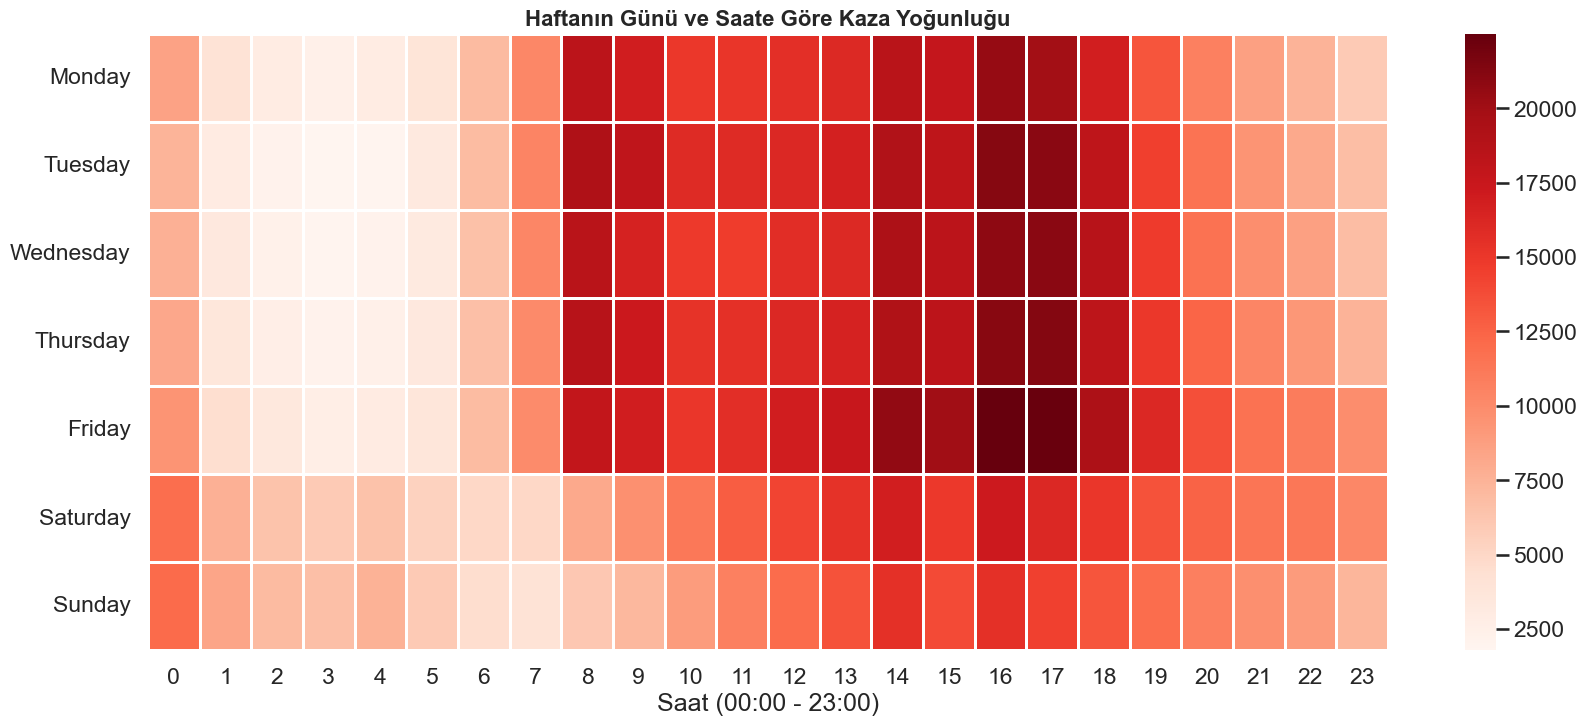

In [2]:
pivot_table_data = data.pivot_table(
    index='DAY_OF_WEEK',
    columns='HOUR',
    values='YEAR',
    aggfunc='count'
)

week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table_data = pivot_table_data.reindex(week_days)

plt.figure(figsize=(20, 8))
sns.heatmap(pivot_table_data, cmap='Reds', linecolor='white', linewidths=1)
plt.title('Haftanın Günü ve Saate Göre Kaza Yoğunluğu', fontsize=16, fontweight='bold')
plt.xlabel('Saat (00:00 - 23:00)')
plt.ylabel('')
plt.show()

C:\Users\umutk\AppData\Local\Temp\ipykernel_12508\2258227306.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


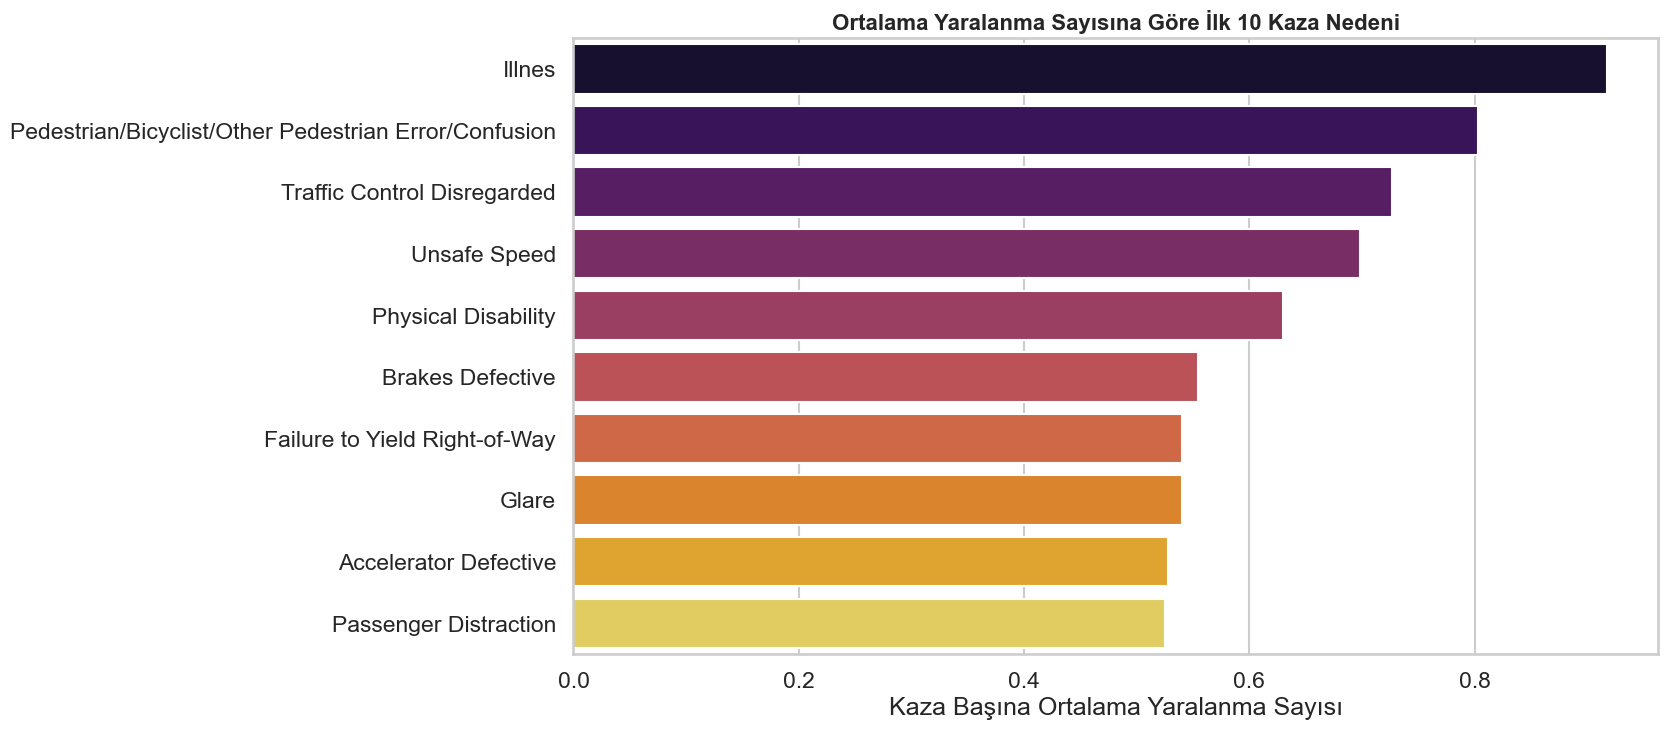

In [3]:
popular_causes = data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
popular_causes = popular_causes[popular_causes > 1000].index

risk_analysis = data[data['CONTRIBUTING FACTOR VEHICLE 1'].isin(popular_causes)]
risk_order = risk_analysis.groupby('CONTRIBUTING FACTOR VEHICLE 1')['NUMBER OF PERSONS INJURED'] \
    .mean().sort_values(ascending=False).head(10).index

plt.figure(figsize=(14, 8))
sns.barplot(
    data=risk_analysis,
    y='CONTRIBUTING FACTOR VEHICLE 1',
    x='NUMBER OF PERSONS INJURED',
    order=risk_order,
    palette='inferno',
    errorbar=None
)
plt.title('Ortalama Yaralanma Sayısına Göre İlk 10 Kaza Nedeni', fontsize=16, fontweight='bold')
plt.xlabel('Kaza Başına Ortalama Yaralanma Sayısı')
plt.ylabel('')
plt.show()

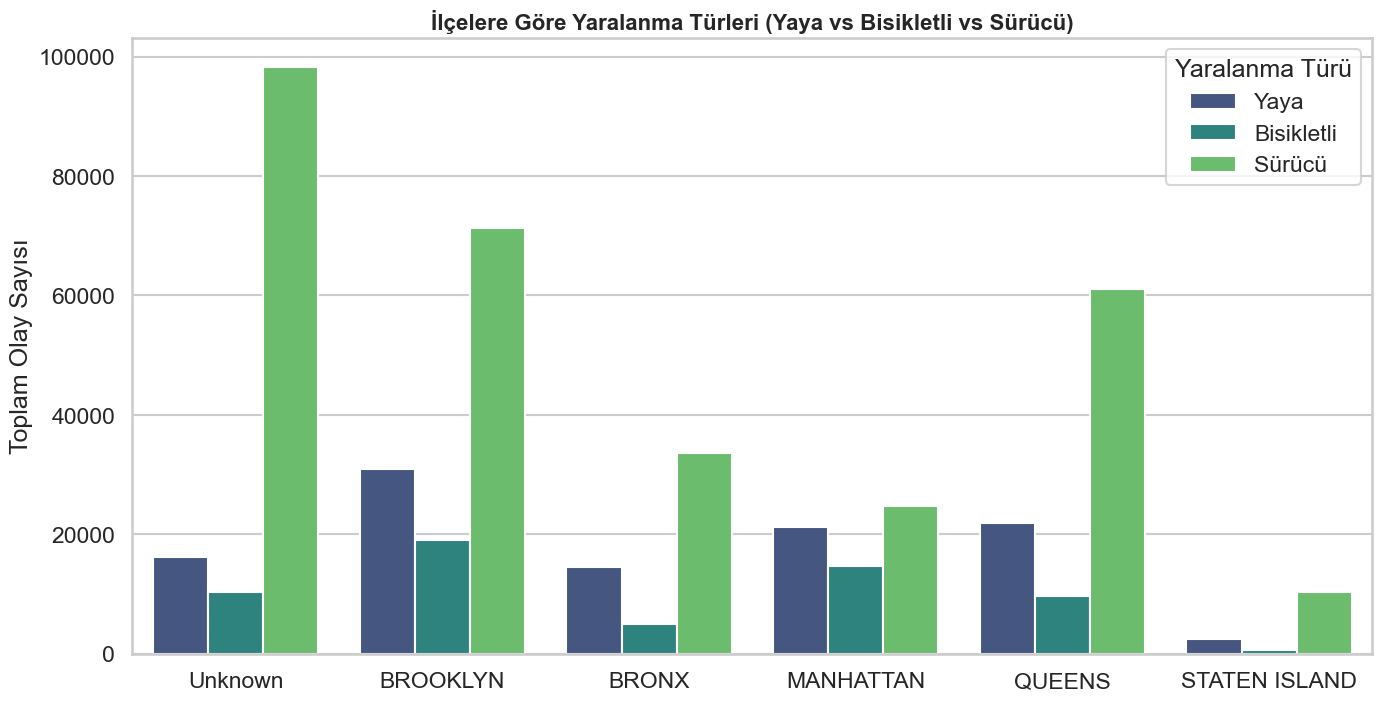

In [4]:
injury_types = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
data_melted = data.melt(id_vars=['BOROUGH'], value_vars=injury_types, var_name='Injury_Type', value_name='Count')
data_melted = data_melted[data_melted['Count'] > 0]

plt.figure(figsize=(16, 8))
sns.countplot(data=data_melted, x='BOROUGH', hue='Injury_Type', palette='viridis')
plt.title('İlçelere Göre Yaralanma Türleri (Yaya vs Bisikletli vs Sürücü)', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('Toplam Olay Sayısı')
plt.legend(title='Yaralanma Türü', labels=['Yaya', 'Bisikletli', 'Sürücü'])
plt.show()

DOLDURMADAN ÖNCE:
BOROUGH
BROOKLYN         476009
Unknown          472343
QUEENS           398889
MANHATTAN        326463
BRONX            217245
STATEN ISLAND     62078
Name: count, dtype: int64

Kurtarılacak 472343 kayıt bulundu. KNN çalıştırılıyor...

TAMAMLANDI! 'Bilinmeyen' ilçeler koordinatlara göre dolduruldu.

DOLDURMA SONRASI (Temizlenmiş):
BOROUGH
BROOKLYN         598268
QUEENS           557019
MANHATTAN        409743
BRONX            291366
STATEN ISLAND     96631
Name: count, dtype: int64


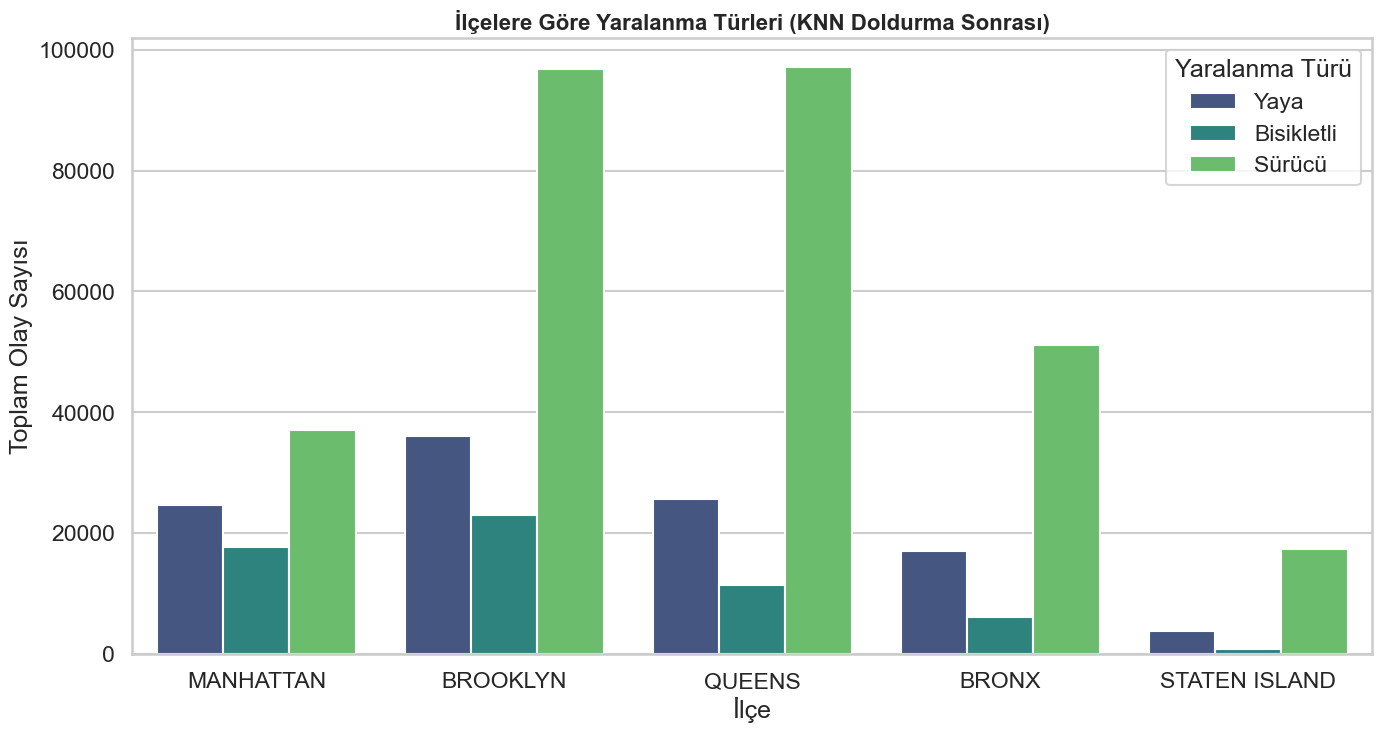

In [5]:
from sklearn.neighbors import KNeighborsClassifier

print("DOLDURMADAN ÖNCE:")
print(data['BOROUGH'].value_counts())

train_data = data[
    (data['BOROUGH'] != 'Unknown') &
    (data['LATITUDE'].notna()) &
    (data['LONGITUDE'].notna())
]

predict_data = data[
    (data['BOROUGH'] == 'Unknown') &
    (data['LATITUDE'].notna()) &
    (data['LONGITUDE'].notna())
]

if len(predict_data) > 0:
    print(f"\nKurtarılacak {len(predict_data)} kayıt bulundu. KNN çalıştırılıyor...")

    knn = KNeighborsClassifier(n_neighbors=3)

    X_train = train_data[['LATITUDE', 'LONGITUDE']]
    y_train = train_data['BOROUGH']

    knn.fit(X_train, y_train)

    X_predict = predict_data[['LATITUDE', 'LONGITUDE']]
    predicted_boroughs = knn.predict(X_predict)

    data.loc[predict_data.index, 'BOROUGH'] = predicted_boroughs

    print("\nTAMAMLANDI! 'Bilinmeyen' ilçeler koordinatlara göre dolduruldu.")
else:
    print("\nDoldurulacak 'Bilinmeyen' veri yok veya eksik koordinatlar.")

print("\nDOLDURMA SONRASI (Temizlenmiş):")
print(data['BOROUGH'].value_counts())

injury_types = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
data_melted = data.melt(id_vars=['BOROUGH'], value_vars=injury_types, var_name='Injury_Type', value_name='Count')
data_melted = data_melted[data_melted['Count'] > 0]

plt.figure(figsize=(16, 8))
sns.countplot(data=data_melted, x='BOROUGH', hue='Injury_Type', palette='viridis')
plt.title('İlçelere Göre Yaralanma Türleri (KNN Doldurma Sonrası)', fontsize=16, fontweight='bold')
plt.xlabel('İlçe')
plt.ylabel('Toplam Olay Sayısı')
plt.legend(title='Yaralanma Türü', labels=['Yaya', 'Bisikletli', 'Sürücü'])
plt.show()

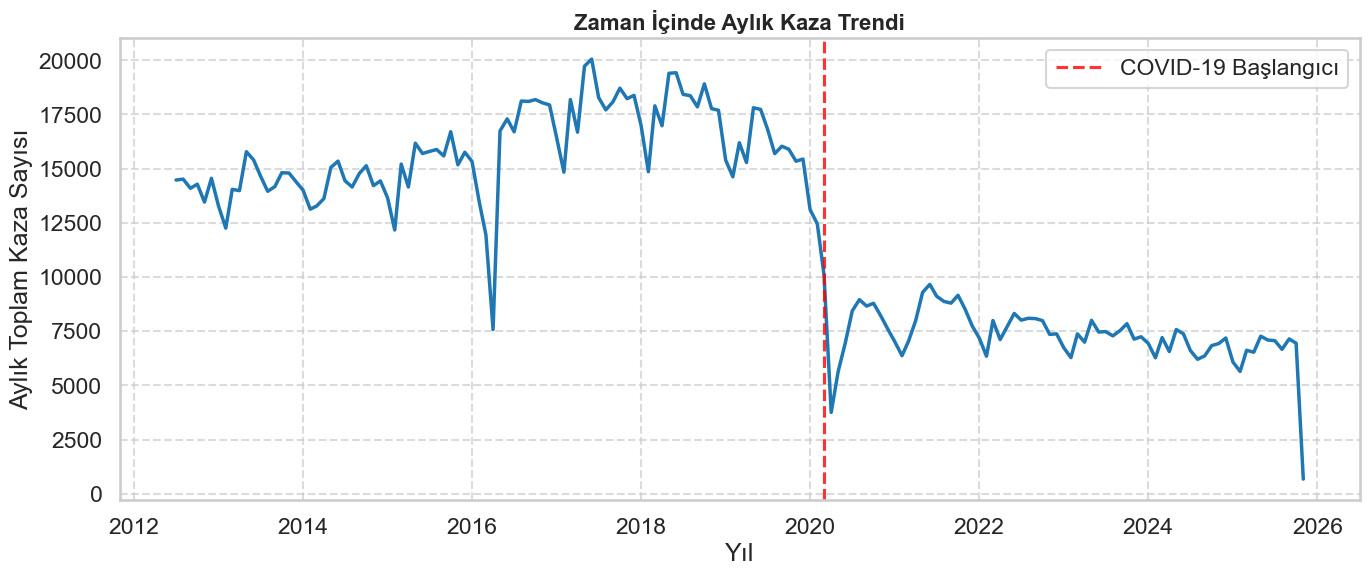

In [6]:
monthly_accidents = data.groupby(['YEAR', 'MONTH']).size().reset_index(name='Accident_Count')
monthly_accidents['Date'] = pd.to_datetime(monthly_accidents[['YEAR', 'MONTH']].assign(DAY=1))

plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_accidents, x='Date', y='Accident_Count', linewidth=2.5, color='#1f77b4')

plt.title('Zaman İçinde Aylık Kaza Trendi', fontsize=16, fontweight='bold')
plt.xlabel('Yıl')
plt.ylabel('Aylık Toplam Kaza Sayısı')
plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.8, label='COVID-19 Başlangıcı')
plt.legend()
plt.show()

In [7]:
file_name = 'Processed_Data.csv'

data.to_csv(file_name, index=False)

print("-" * 40)
print("Bu temizlenmiş veri setini artık analiz için doğrudan yükleyebilirsiniz.")
print("-" * 40)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(file_name, low_memory=False)
print(f"Veri Seti Yüklendi. Boyut: {data.shape}")
print(data.columns)
data.head(20)

----------------------------------------
Bu temizlenmiş veri setini artık analiz için doğrudan yükleyebilirsiniz.
----------------------------------------
Veri Seti Yüklendi. Boyut: (1953027, 23)
Index(['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'CROSS STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'YEAR', 'MONTH',
       'DAY_OF_WEEK', 'HOUR', 'LOCATION_TYPE', 'UNIFIED_LOCATION'],
      dtype='object')


,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,YEAR,MONTH,DAY_OF_WEEK,HOUR,LOCATION_TYPE,UNIFIED_LOCATION
0,BROOKLYN,11230,40.621790,-73.970024,AVENUE K,1.0,0.0,0,0,0,...,Unspecified,Unspecified,Moped,Sedan,2023,11,Wednesday,1,On Street,OCEAN PARKWAY
1,BROOKLYN,11208,40.667202,-73.866500,Unknown Cross Street,0.0,0.0,0,0,0,...,Unspecified,NaN,Sedan,NaN,2021,9,Saturday,9,Off Street,1211 LORING AVENUE
2,BROOKLYN,Unknown,40.709183,-73.956825,Unknown Cross Street,0.0,0.0,0,0,0,...,Passing Too Closely,Unspecified,Sedan,Tractor Truck Diesel,2021,12,Tuesday,17,On Street,BROOKLYN QUEENS EXPRESSWAY
3,BRONX,10475,40.868160,-73.831480,Unknown Cross Street,2.0,0.0,0,0,0,...,Unspecified,Unspecified,Sedan,Sedan,2021,12,Tuesday,8,Off Street,344 BAYCHESTER AVENUE
4,BROOKLYN,11207,40.671720,-73.897100,Unknown Cross Street,0.0,0.0,0,0,0,...,Driver Inexperience,Unspecified,Sedan,NaN,2021,12,Tuesday,21,Off Street,2047 PITKIN AVENUE
5,MANHATTAN,10017,40.751440,-73.973970,EAST 43 STREET,0.0,0.0,0,0,0,...,Passing Too Closely,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,2021,12,Tuesday,14,On Street,3 AVENUE
6,QUEENS,Unknown,40.701275,-73.888870,Unknown Cross Street,0.0,0.0,0,0,0,...,Passing or Lane Usage Improper,Unspecified,Station Wagon/Sport Utility Vehicle,NaN,2021,12,Monday,0,On Street,MYRTLE AVENUE
7,QUEENS,11413,40.675884,-73.755770,EAST GATE PLAZA,0.0,0.0,0,0,0,...,Turning Improperly,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,2021,12,Tuesday,16,On Street,SPRINGFIELD BOULEVARD
8,BROOKLYN,Unknown,40.596620,-74.002310,Unknown Cross Street,0.0,0.0,0,0,0,...,Unsafe Speed,NaN,Sedan,NaN,2021,12,Tuesday,0,On Street,BELT PARKWAY
9,QUEENS,11434,40.666840,-73.789410,150 STREET,2.0,0.0,0,0,0,...,Reaction to Uninvolved Vehicle,Unspecified,Sedan,Sedan,2021,12,Tuesday,23,On Street,NORTH CONDUIT AVENUE


In [8]:
severity_conditions = [
    (data['NUMBER OF PERSONS KILLED'] > 0),
    (data['NUMBER OF PERSONS INJURED'] > 0)
]

severity_choices = ['Fatal', 'Injury']

data['SEVERITY'] = np.select(severity_conditions, severity_choices, default='Property Damage Only')

print("-" * 30)
print("SEVERITY sütunu başarıyla eklendi!")
print("-" * 30)
print(data['SEVERITY'].value_counts())
print(data.columns)
data.head(50)

------------------------------
SEVERITY sütunu başarıyla eklendi!
------------------------------
SEVERITY
Property Damage Only    1479320
Injury                   470839
Fatal                      2868
Name: count, dtype: int64
Index(['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'CROSS STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'YEAR', 'MONTH',
       'DAY_OF_WEEK', 'HOUR', 'LOCATION_TYPE', 'UNIFIED_LOCATION', 'SEVERITY'],
      dtype='object')


,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,YEAR,MONTH,DAY_OF_WEEK,HOUR,LOCATION_TYPE,UNIFIED_LOCATION,SEVERITY
0,BROOKLYN,11230,40.621790,-73.970024,AVENUE K,1.0,0.0,0,0,0,...,Unspecified,Moped,Sedan,2023,11,Wednesday,1,On Street,OCEAN PARKWAY,Injury
1,BROOKLYN,11208,40.667202,-73.866500,Unknown Cross Street,0.0,0.0,0,0,0,...,NaN,Sedan,NaN,2021,9,Saturday,9,Off Street,1211 LORING AVENUE,Property Damage Only
2,BROOKLYN,Unknown,40.709183,-73.956825,Unknown Cross Street,0.0,0.0,0,0,0,...,Unspecified,Sedan,Tractor Truck Diesel,2021,12,Tuesday,17,On Street,BROOKLYN QUEENS EXPRESSWAY,Property Damage Only
3,BRONX,10475,40.868160,-73.831480,Unknown Cross Street,2.0,0.0,0,0,0,...,Unspecified,Sedan,Sedan,2021,12,Tuesday,8,Off Street,344 BAYCHESTER AVENUE,Injury
4,BROOKLYN,11207,40.671720,-73.897100,Unknown Cross Street,0.0,0.0,0,0,0,...,Unspecified,Sedan,NaN,2021,12,Tuesday,21,Off Street,2047 PITKIN AVENUE,Property Damage Only
5,MANHATTAN,10017,40.751440,-73.973970,EAST 43 STREET,0.0,0.0,0,0,0,...,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,2021,12,Tuesday,14,On Street,3 AVENUE,Property Damage Only
6,QUEENS,Unknown,40.701275,-73.888870,Unknown Cross Street,0.0,0.0,0,0,0,...,Unspecified,Station Wagon/Sport Utility Vehicle,NaN,2021,12,Monday,0,On Street,MYRTLE AVENUE,Property Damage Only
7,QUEENS,11413,40.675884,-73.755770,EAST GATE PLAZA,0.0,0.0,0,0,0,...,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,2021,12,Tuesday,16,On Street,SPRINGFIELD BOULEVARD,Property Damage Only
8,BROOKLYN,Unknown,40.596620,-74.002310,Unknown Cross Street,0.0,0.0,0,0,0,...,NaN,Sedan,NaN,2021,12,Tuesday,0,On Street,BELT PARKWAY,Property Damage Only
9,QUEENS,11434,40.666840,-73.789410,150 STREET,2.0,0.0,0,0,0,...,Unspecified,Sedan,Sedan,2021,12,Tuesday,23,On Street,NORTH CONDUIT AVENUE,Injury


In [9]:
columns_to_remove = [
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED'
]

data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

print("-" * 40)
print("TÜM SAYISAL SÜTUNLAR SİLİNDİ!")
print("-" * 40)

print("Model için kullanılabilir özellikler:")

data.to_csv('NYC_Crash_Cleaned_Severity.csv', index=False)
print(data.columns)
print(data.shape)
data.head(50)

----------------------------------------
TÜM SAYISAL SÜTUNLAR SİLİNDİ!
----------------------------------------
Model için kullanılabilir özellikler:
Index(['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'CROSS STREET NAME',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'YEAR', 'MONTH',
       'DAY_OF_WEEK', 'HOUR', 'LOCATION_TYPE', 'UNIFIED_LOCATION', 'SEVERITY'],
      dtype='object')
(1953027, 16)


,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,CROSS STREET NAME,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,YEAR,MONTH,DAY_OF_WEEK,HOUR,LOCATION_TYPE,UNIFIED_LOCATION,SEVERITY
0,BROOKLYN,11230,40.621790,-73.970024,AVENUE K,Unspecified,Unspecified,Moped,Sedan,2023,11,Wednesday,1,On Street,OCEAN PARKWAY,Injury
1,BROOKLYN,11208,40.667202,-73.866500,Unknown Cross Street,Unspecified,NaN,Sedan,NaN,2021,9,Saturday,9,Off Street,1211 LORING AVENUE,Property Damage Only
2,BROOKLYN,Unknown,40.709183,-73.956825,Unknown Cross Street,Passing Too Closely,Unspecified,Sedan,Tractor Truck Diesel,2021,12,Tuesday,17,On Street,BROOKLYN QUEENS EXPRESSWAY,Property Damage Only
3,BRONX,10475,40.868160,-73.831480,Unknown Cross Street,Unspecified,Unspecified,Sedan,Sedan,2021,12,Tuesday,8,Off Street,344 BAYCHESTER AVENUE,Injury
4,BROOKLYN,11207,40.671720,-73.897100,Unknown Cross Street,Driver Inexperience,Unspecified,Sedan,NaN,2021,12,Tuesday,21,Off Street,2047 PITKIN AVENUE,Property Damage Only
5,MANHATTAN,10017,40.751440,-73.973970,EAST 43 STREET,Passing Too Closely,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,2021,12,Tuesday,14,On Street,3 AVENUE,Property Damage Only
6,QUEENS,Unknown,40.701275,-73.888870,Unknown Cross Street,Passing or Lane Usage Improper,Unspecified,Station Wagon/Sport Utility Vehicle,NaN,2021,12,Monday,0,On Street,MYRTLE AVENUE,Property Damage Only
7,QUEENS,11413,40.675884,-73.755770,EAST GATE PLAZA,Turning Improperly,Unspecified,Sedan,Station Wagon/Sport Utility Vehicle,2021,12,Tuesday,16,On Street,SPRINGFIELD BOULEVARD,Property Damage Only
8,BROOKLYN,Unknown,40.596620,-74.002310,Unknown Cross Street,Unsafe Speed,NaN,Sedan,NaN,2021,12,Tuesday,0,On Street,BELT PARKWAY,Property Damage Only
9,QUEENS,11434,40.666840,-73.789410,150 STREET,Reaction to Uninvolved Vehicle,Unspecified,Sedan,Sedan,2021,12,Tuesday,23,On Street,NORTH CONDUIT AVENUE,Injury


In [ ]:
data = pd.get_dummies(data, columns=['BOROUGH'], prefix='BOROUGH', dtype=int)

print("BOROUGH başarıyla one-hot encoded yapıldı")


print("-DÖNÜŞÜM SONRASI-")
new_columns = [col for col in data.columns if 'BOROUGH' in col or 'SEVERITY' in col]
print(data[new_columns].head())

BOROUGH başarıyla one-hot encoded yapıldı
--- DÖNÜŞÜM SONRASI ---
               SEVERITY  BOROUGH_BRONX  BOROUGH_BROOKLYN  BOROUGH_MANHATTAN  \
0                Injury              0                 1                  0   
1  Property Damage Only              0                 1                  0   
2  Property Damage Only              0                 1                  0   
3                Injury              1                 0                  0   
4  Property Damage Only              0                 1                  0   

   BOROUGH_QUEENS  BOROUGH_STATEN ISLAND  
0               0                      0  
1               0                      0  
2               0                      0  
3               0                      0  
4               0                      0  
